In [1]:
print('###############################################   LAB 6   ##############################################')
print('################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2022 ############')
print('##################### DEEP LEARNING FOR SEQUENCE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE ##############')
print('########################################################################################################')

###############################################   LAB 6   ##############################################
################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2022 ############
##################### DEEP LEARNING FOR SEQUENCE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE ##############
########################################################################################################


In [2]:
import torch
import torch.nn as nn
from torchvision import models
import os, sys
from pathlib import Path
import numpy as np
import net_ucf11
from PIL import Image as Image
from torchvision import transforms, utils, models
import pickle
import matplotlib.pyplot as plt
import torch.utils.data as data
import dataset_ucf11
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from matplotlib import pyplot as plt

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')

print ('Device set to {0}'.format(device))

epoch = 10
learning_rate = 1e-6
#batch size: number of data samples in the current batch
sample_size = 2
# ResNet101
feature_extractor_base = net_ucf11.resnet101(fc_layer=False, zero_init_residual=True)
# LSTM
rnn = net_ucf11.rnn_model()

print(feature_extractor_base)
print(rnn)

Device set to cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), b

In [4]:
state_dict = load_state_dict_from_url(net_ucf11.model_urls['resnet101'], progress = True)
for k,par in state_dict.items():    
    if k in feature_extractor_base.state_dict().keys() and par.size() == feature_extractor_base.state_dict()[k].size():
        feature_extractor_base.state_dict()[k].copy_(par)
        print("Copying weights into {}".format(k))
    else:
        print("Weight dimensions mismatch for {}".format(k))


Copying weights into conv1.weight
Copying weights into bn1.running_mean
Copying weights into bn1.running_var
Copying weights into bn1.weight
Copying weights into bn1.bias
Copying weights into layer1.0.conv1.weight
Copying weights into layer1.0.bn1.running_mean
Copying weights into layer1.0.bn1.running_var
Copying weights into layer1.0.bn1.weight
Copying weights into layer1.0.bn1.bias
Copying weights into layer1.0.conv2.weight
Copying weights into layer1.0.bn2.running_mean
Copying weights into layer1.0.bn2.running_var
Copying weights into layer1.0.bn2.weight
Copying weights into layer1.0.bn2.bias
Copying weights into layer1.0.conv3.weight
Copying weights into layer1.0.bn3.running_mean
Copying weights into layer1.0.bn3.running_var
Copying weights into layer1.0.bn3.weight
Copying weights into layer1.0.bn3.bias
Copying weights into layer1.0.downsample.0.weight
Copying weights into layer1.0.downsample.1.running_mean
Copying weights into layer1.0.downsample.1.running_var
Copying weights into

In [5]:
feature_extractor_base = feature_extractor_base.to(device)
rnn = rnn.to(device)

In [6]:
s = '../data/lab6/ucf11_train_data/data/diving_0'
# frames = sorted(os.listdir(s), key=lambda x: int(x.split('.')[0]))
frames = sorted(Path(s).glob("*.jpg"), key = lambda x: int(x.stem))
frames[:5], len(frames)

([PosixPath('../data/lab6/ucf11_train_data/data/diving_0/00001.jpg'),
  PosixPath('../data/lab6/ucf11_train_data/data/diving_0/00002.jpg'),
  PosixPath('../data/lab6/ucf11_train_data/data/diving_0/00003.jpg'),
  PosixPath('../data/lab6/ucf11_train_data/data/diving_0/00004.jpg'),
  PosixPath('../data/lab6/ucf11_train_data/data/diving_0/00005.jpg')],
 259)

In [9]:
#load images and label
def load_data(stage, image_size = 128):
    # all data here
    if stage == "train":
        source_dir = '../data/lab6/ucf11_train_data/data'

    # list of folders with videos: 1,2,
    # image transform
    # Resize transform takes a Pillow image object
    transform_train_img = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])
    # select frames
    # this will be the dimensions of one data point, 
    # seq_length x H x W
    min_frame = 0
    max_frame = 50
    seq_length = max_frame - min_frame
    params = {'batch_size':sample_size, 'shuffle':True}
    # this will return the data for ONE video
    data_point = dataset_ucf11.DatasetUCF11(source_dir, seq_length, transform_train_img)
    dataset = data.DataLoader(data_point, **params)
    return dataset

In [10]:
train_data = load_data("train")

In [11]:
type(train_data)
# train_features, train_labels = 
a, b, c = next(iter(train_data))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
type(a), type(b), type(c)
a.shape, b.shape, c.shape

(torch.Size([2]), torch.Size([2, 50, 3, 128, 128]), torch.Size([2, 1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

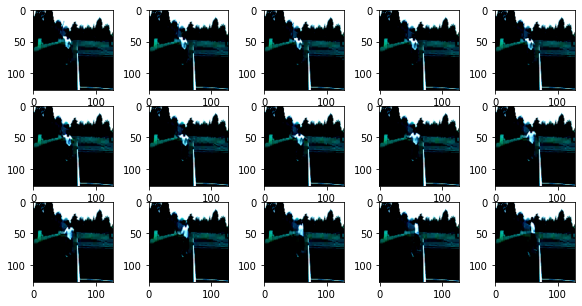

In [13]:
fig, axs = plt.subplots(3,5,figsize=(10,5))

for i, ax in enumerate(axs.flatten()):
    img = b[0,i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    
fig.show()

In [14]:
def train_convnet_lstm():
    # set both networks to train mode
    # get data, instantiated only once 
    train_data = load_data("train")    
    model_params = list(feature_extractor_base.parameters())+list(rnn.parameters())
    feature_extractor_base.train()
    rnn.train()
    optimizer = torch.optim.Adam(model_params, lr=learning_rate)
    # softmax + loglikelihood
    loss_function = nn.CrossEntropyLoss()
    loss_function = loss_function.to(device)
    loss_hist = []
    for e in range(epoch):
        print ('Current epoch = {0:d}'.format(e))
        total_loss = 0  
        optimizer.zero_grad()
        for idx, X, y in train_data:
            optimizer.zero_grad()            
            X, y = X.to(device), y.to(device) 
            output = rnn(feature_extractor_base(X))
            loss = loss_function(output, y.view(-1)) 
            loss_hist.append(loss)
            # increment epoch loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        # average loss this epoch, divide by the number of batches in the dataset
        total_loss = total_loss/len(train_data)
        loss_hist.append(total_loss)
        print('Total loss for epoch {0:} = {1:.3f}'.format(e, total_loss))

In [15]:
train_convnet_lstm()

Current epoch = 0


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Total loss for epoch 0 = 2.405
Current epoch = 1
Total loss for epoch 1 = 2.394
Current epoch = 2
Total loss for epoch 2 = 2.395
Current epoch = 3
Total loss for epoch 3 = 2.397
Current epoch = 4
Total loss for epoch 4 = 2.397
Current epoch = 5
Total loss for epoch 5 = 2.389
Current epoch = 6
Total loss for epoch 6 = 2.387
Current epoch = 7
Total loss for epoch 7 = 2.396
Current epoch = 8
Total loss for epoch 8 = 2.390
Current epoch = 9
Total loss for epoch 9 = 2.403
